# Libraries

In [10]:
import jax, optax, flax
import pickle
import functools
import matplotlib.pyplot, matplotlib.animation
import numpy

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_disable_jit', True) # Desactive the compilation for better debugging
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Neural Network

In [11]:
class MLP(flax.linen.Module):
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure, activation function and a bool to indicates if it's occurring a training
     """
    layers: list
    training: bool

    @flax.linen.compact
    def __call__(self, x):
        """
        Compute the output of the neural network
        Parameters
        ----------
        x : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        x : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- numerical output of the neural network	(u,v,p)
        """
        
        x = flax.linen.BatchNorm(use_running_average=not self.training)(x)
        for i in range(1,len(self.layers)-1):
            x = flax.linen.Dense(self.layers[i])(x)
            x = flax.linen.BatchNorm(use_running_average=not self.training)(x)
            x = flax.linen.tanh(x)
            #x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = flax.linen.Dense(self.layers[-1])(x)
        
        return x

# PDE Operators

In [12]:
class PDE_operators:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self, psi_function, c_function, cg_function, solution):
        self.psi_function = psi_function
        self.c_function = c_function
        self.cg_function = cg_function
        self.solution = solution


    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_psi(self, params, inputs):
        """
        Compute the gradient of the psi function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        gradient : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient applied to the inputs
        """

        fun = lambda params, x, y: self.psi_function(params, x, y)

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(fun, 1)(params, x, y)
            u_y = jax.jacfwd(fun, 2)(params, x, y)
            return jax.numpy.column_stack((u_x, u_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

        return gradient

    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_c_cg_psi(self, params, inputs):
        """
        Compute the gradient nabla(c*cg*psi)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        res : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient nabla(c*cg*psi) applied to the inputs
        """

        fun = lambda params, x, y: self.psi_function(params, x, y)*self.c_function(x,y)*self.cg_function(x,y)

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(fun, 1)(params, x, y)
            u_y = jax.jacfwd(fun, 2)(params, x, y)
            return jax.numpy.column_stack((u_x, u_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

        return gradient

    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_c_cg(self, params, inputs):
        """
        Compute the gradient nabla(c*cg)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        res : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient nabla(c*cg) applied to the inputs
        """

        fun = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(fun, 1)(params, x, y)
            u_y = jax.jacfwd(fun, 2)(params, x, y)
            return jax.numpy.column_stack((u_x, u_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

    @functools.partial(jax.jit, static_argnums=(0,))    
    def dsol_dt(self, params, inputs):
        """
        Compute the time derivative os the solution
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,z,t)
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- numerical values of the time derivative applied to the inputs
        """

        fun = lambda params, x, y, z, t: self.solution(params, x, y, z, t)

        @functools.partial(jax.jit)    
        def action(params, x, y, z, t):               # function to vectorize the laplacian
            u_t = jax.jacfwd(fun, 4)(params, x, y, z, t)
            return u_t

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3])

        return res.reshape(-1)


# PINN

In [13]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self, NN_evaluation, optimizer):
        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer

        self.operators = PDE_operators(self.spatial_solution2d, self.c_coeff, self.cg_coeff, self.solution)
        self.gradient_psi = self.operators.comp_grad_psi
        self.dsol_dt = self.operators.dsol_dt
        self.gradient_c_cg_psi = self.operators.comp_grad_c_cg_psi
        self.gradient_c_cg = self.operators.comp_grad_c_cg
    


    #########################################################
    ################### Solution domain 2d ##################
    #########################################################
    def spatial_solution2d(self, params, inputX, inputY):
        """
        Compute the solution of the PDE on the points (x,y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the mesh
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the mesh
        Returns
        -------
        applied_solution : jax.numpy.ndarray[batch_size]
            -- PINN solution applied to inputs. return u, a complex number
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        NN_output = jax.lax.complex(NN[:,0],NN[:,1])   # The first output of the NN is the real part, the second is the imaginary part
        
        return NN_output


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_residual_pde(self, params, inputs):
        """
        Compute the residual of the pde inside the domain
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points from the mesh
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inputs
        """

        pred_1 = self.k_coeff(inputs[:,0],inputs[:,1])**2*self.c_coeff(inputs[:,0],inputs[:,1])*self.cg_coeff(inputs[:,0],inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])**2
        pred_2 = 0 #temporary, H constant implies grad(c*c_g) = 0, grad function not working
        #pred_2 = self.spatial_solution2d(params, inputs[:,0], inputs[:,1])*jax.numpy.einsum('ij,ij->i', self.gradient_psi(params, inputs), self.gradient_c_cg(params, inputs))
        pred_3 = jax.numpy.einsum('ij,ij->i', self.gradient_psi(params, inputs), self.gradient_c_cg_psi(params,inputs))
        loss_value = jax.numpy.mean(pred_1 + pred_2 - pred_3)
        
        return loss_value


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_absorbing_boundary(self, params, inputs):
        """
        Compute the loss function at the top, bottom and right boundaries
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_absorbing : a float.64
            -- loss function applied to inputs
        """
        preds_absorbing = jax.lax.complex(-jax.numpy.imag(self.k_coeff(inputs[:,0], inputs[:,1])*self.c_coeff(inputs[:,0], inputs[:,1])*self.cg_coeff(inputs[:,0], inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])**2), jax.numpy.real(self.k_coeff(inputs[:,0], inputs[:,1])*self.c_coeff(inputs[:,0], inputs[:,1])*self.cg_coeff(inputs[:,0], inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])**2))
        loss_absorbing = jax.numpy.mean(preds_absorbing)
      
        return loss_absorbing


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_incident_boundary(self, params, inputs):
        """
        Compute the loss function at the left open boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_incident : a float.64
            -- loss function applied to inputs
        """
        preds_incident = jax.lax.complex(-jax.numpy.imag(self.k_coeff(inputs[:,0], inputs[:,1])*self.c_coeff(inputs[:,0], inputs[:,1])*self.cg_coeff(inputs[:,0], inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])*(2*self.incident_psi(params, inputs)-self.spatial_solution2d(params, inputs[:,0], inputs[:,1]))), jax.numpy.real(self.k_coeff(inputs[:,0], inputs[:,1])*(2*self.incident_psi(params, inputs)-self.spatial_solution2d(params, inputs[:,0], inputs[:,1]))))
        loss_incident = jax.numpy.mean(preds_incident)
      
        return loss_incident


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_function(self, params, inside, reflective, absorbing, incident):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss_sum : a float.64
            -- loss function applied to inputs
        losses : numpy.array(loss_residual, loss_bound, loss_front_behind)
            -- current values of each loss function
        """

        loss1 = self.loss_incident_boundary(params, incident) 
        loss2 = self.loss_absorbing_boundary(params, absorbing)

        loss_bound = loss1 + loss2
        loss_residual = self.loss_residual_pde(params, inside)
        loss_sum = loss_bound + loss_residual
        losses = jax.numpy.array([loss_residual, loss_bound])

        return loss_sum, losses


    @functools.partial(jax.jit, static_argnums=(0,))    
    def train_step(self, params, opt_state, inside, reflective, absorbing, incident):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside, reflective, absorbing, incident)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses




    #########################################################
    #################### Physical domain ####################
    #########################################################
    @functools.partial(jax.jit, static_argnums=(0,))    
    def omega_coeff(self, x, y):
        """
        Compute the frequency omega at in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        omega : jax.numpy.ndarray[batch_size]
            -- omega in each couple (x,y)
        """
        omega = jax.numpy.sqrt(9.81*self.k_coeff(x,y)*jax.numpy.tanh(self.k_coeff(x,y)*self.height_function(x,y)))
        
        return omega


    @functools.partial(jax.jit, static_argnums=(0,))    
    def k_coeff(self, x, y):
        """
        Compute the coefficient k in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        k : jax.numpy.ndarray[batch_size]
            -- Coefficient k in each couple (x,y)
        """

        return 0.5


    @functools.partial(jax.jit, static_argnums=(0,))    
    def c_coeff(self, x, y):
        """
        Compute the coefficient c in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        c : jax.numpy.ndarray[batch_size]
            -- Coefficient c in each couple (x,y)
        """
        c = self.omega_coeff(x,y)/self.k_coeff(x,y)

        return c


    @functools.partial(jax.jit, static_argnums=(0,))    
    def cg_coeff(self, x, y):
        """
        Compute the coefficient cg in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        cg : jax.numpy.ndarray[batch_size]
            -- Coefficient cg in each couple (x,y)
        """
        nprime = 0.5*(1 + 2*self.k_coeff(x,y)*self.height_function(x,y)/jax.numpy.sinh(2*self.k_coeff(x,y)*self.height_function(x,y)))
        cg = nprime*self.omega_coeff(x,y)/self.k_coeff(x,y)

        return cg


    @functools.partial(jax.jit, static_argnums=(0,))    
    def height_function(self, x, y):
        """
        Compute the height in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        h : jax.numpy.ndarray[batch_size]
            -- Height each couple (x,y)
        """

        return 10


    @functools.partial(jax.jit, static_argnums=(0,))    
    def f_dependence(self, inputX, inputY, inputZ):
        """
        Compute the function fz in the point (x,y,z)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        Returns
        -------
        fz : jax.numpy.ndarray[batch_size]
            -- fz in each point (x,y,z)
        """
        fz = (jax.numpy.cosh(self.k_coeff(inputX, inputY)*(self.height_function(inputX, inputY)+ inputZ))/jax.numpy.cosh(self.k_coeff(inputX, inputY)*self.height_function(inputX, inputY))).reshape(-1)

        return fz


    @functools.partial(jax.jit, static_argnums=(0,))    
    def solution(self, params, x,y,z,t):
        """
        Compute the solution in the point (x,y,z,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- result in each point (x,y,z,t)
        """
        H = 2*self.omega_coeff(x,y)*abs(self.spatial_solution2d(params,x,y))/9.81
        #res = jax.numpy.real(9.81*H/(2*self.omega_coeff(x,y))*self.spatial_solution2d(params, x,y)*self.f_dependence(x,y,z)*jax.numpy.exp(jax.lax.complex(0.0,-self.omega_coeff(x,y)*t)))
        res = jax.numpy.imag(9.81*H/(2*self.omega_coeff(x,y))*self.spatial_solution2d(params, x,y)*self.f_dependence(x,y,z)*jax.numpy.exp(jax.lax.complex(0.0,jax.numpy.real(-self.omega_coeff(x,y)*t))))

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def elevation(self, params, x,y,t):
        """
        Compute the surface displacement in the point (x,y,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- Displacement in each point (x,y,z,t)
        """
        inputs = jax.numpy.column_stack((x,y,jax.numpy.zeros_like(y),t))
        res = -self.dsol_dt(params, inputs)/9.81

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def incident_psi(self, params, inputs, a=0.01):
        """
        Compute the incident wave in inputs points
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points in the mesh
        Returns
        -------
        incident_wave : a float.64
            -- incident_wave applied to inputs
        """
        incident_wave = (2*a*9.81/self.c_coeff(inputs[:,0], inputs[:,1])*jax.numpy.exp(-self.k_coeff(inputs[:,0],inputs[:,1])*inputs[:,1])).reshape(-1)
        
        return incident_wave


# Parameters

In [14]:
# Neural network parameters
SEED = 351
n_features, n_targets = 2, 1            # Input and output dimension 
layers = [n_features, 50, 50, 50, 50, 50, n_targets]             # Layers structure
lr_scheduler = optax.linear_schedule(0.0005, 0.00001, transition_steps = 50, transition_begin = 5000)
#lr_scheduler = 0.00001               # learning rate
optimizer = optax.adam(lr_scheduler)

# Training parameters
maximum_num_epochs = 10000       
report_steps = 1000
options = 1 # If 1 we start a new training

# Data parameters
N_inside = 128                # number of points inside the mesh
N_bound = 64                   # number of points at the boundary
domain_bounds = jax.numpy.vstack(([0,11], [0,25]))      # minimal and maximal value of each axis (x,y)

# Initialization

In [15]:
training_model = MLP(layers,training=True)     
key1, key2, key3 = jax.random.split(jax.random.PRNGKey(SEED), 3)
x = jax.random.uniform(key1, (10, layers[0]))
params = training_model.init({'params': key2}, x)

eval_model = MLP(layers,training=False)
NN_eval = eval_model.apply   # Evaluate function

solver = PINN(NN_eval, optimizer)
opt_state = optimizer.init(params)

# Data

In [16]:
#### Boundary data
## Free boundary top/bottom
X, Y = jax.numpy.meshgrid(jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4),jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],2))
X, Y = X.flatten(), Y.flatten()
top_bottom = jax.numpy.column_stack((X,Y))

## Free boundary right
X, Y = jax.numpy.meshgrid(jax.numpy.linspace(domain_bounds[0,1],domain_bounds[0,1],1),jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4))
X, Y = X.flatten(), Y.flatten()
right = jax.numpy.column_stack((X,Y))

## Breakwater left
X, Y = jax.numpy.meshgrid(jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,0],1),jax.numpy.concatenate((jax.numpy.linspace(0,10,N_bound//10), jax.numpy.linspace(15,25,N_bound//10)), axis=None))
X, Y = X.flatten(), Y.flatten()
XY_left = jax.numpy.column_stack((X,Y))

## Breakwater opening
X, Y = jax.numpy.meshgrid(jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,0],1),jax.numpy.linspace(10,15,N_bound//10))
X, Y = X.flatten(), Y.flatten()
XY_left_open = jax.numpy.column_stack((X,Y))

XY_bound_absorbing = jax.numpy.concatenate((right, top_bottom))

#### Inside data
# ran_key, batch_key = jax.random.split(jax.random.PRNGKey(0))
# XY_inside = jax.random.uniform(batch_key, shape=(N_inside, n_features-1), minval=domain_bounds[:2,0], maxval=domain_bounds[:2,1])

x = jax.numpy.linspace(domain_bounds[0,0]+5/int(jax.numpy.sqrt(N_inside)),domain_bounds[0,1]-5/int(jax.numpy.sqrt(N_inside)), int(jax.numpy.sqrt(N_inside)))
y = jax.numpy.linspace(domain_bounds[1,0]+5/int(jax.numpy.sqrt(N_inside)),domain_bounds[1,1]-5/int(jax.numpy.sqrt(N_inside)),int(jax.numpy.sqrt(N_inside)))
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
XY_inside = jax.numpy.column_stack((x, y))

Number of points on the boundary: 66
Number of points inside the domain: 121


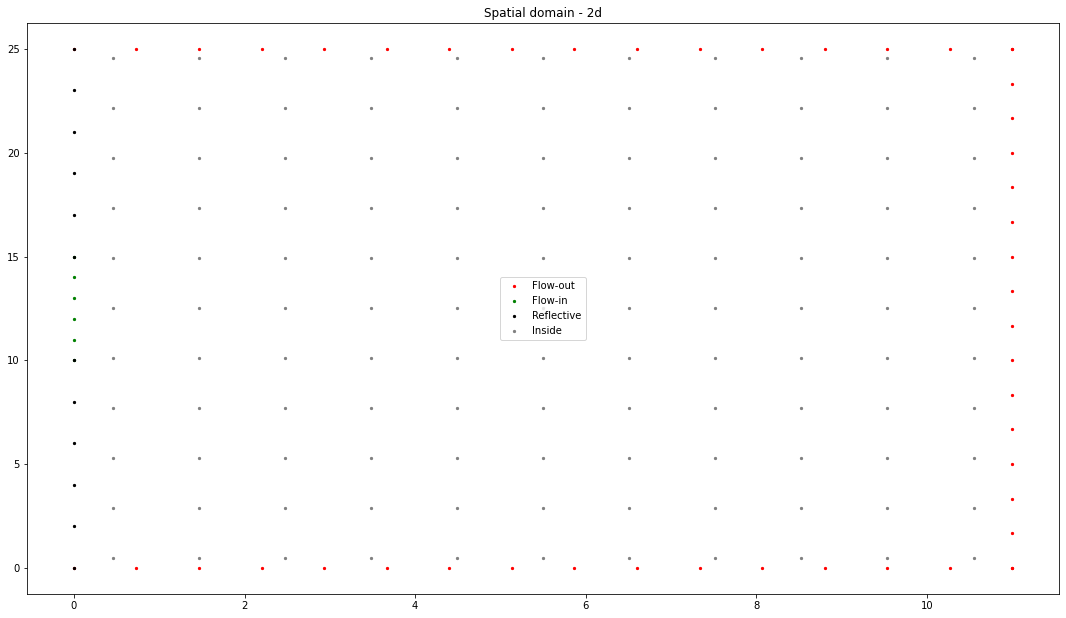

In [17]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18.5, 10.5)
title = ax.set_title('Spatial domain - 2d')
graph = matplotlib.pyplot.scatter(XY_bound_absorbing[:,0],XY_bound_absorbing[:,1],color='red',s=5)
graph = matplotlib.pyplot.scatter(XY_left_open[:,0],XY_left_open[:,1],color='green',s=5)
graph = matplotlib.pyplot.scatter(XY_left[:,0],XY_left[:,1],color='black',s=5)
graph = matplotlib.pyplot.scatter(XY_inside[:,0],XY_inside[:,1], color='gray', s=5)
__ = ax.legend(['Flow-out','Flow-in','Reflective','Inside'])
print('Number of points on the boundary:', XY_bound_absorbing.shape[0]+XY_left_open.shape[0]+XY_left.shape[0])
print('Number of points inside the domain:', XY_inside.shape[0])

matplotlib.pyplot.savefig('./images/domain2d.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()

# Train

In [18]:
if options == 1:            # begin a new training
    loss_history = []
    loss_i = []               # residual loss
    loss_b = []               # boundary loss

    # Main loop to solve the PDE
    for ibatch in range(maximum_num_epochs+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, XY_inside, XY_left, XY_bound_absorbing, XY_left_open)

        loss_i.append(float(losses[0]))
        loss_b.append(float(losses[1]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%report_steps == report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
                pickle.dump(params, open("./NN_saves/params_checkpoint_mild_slope", "wb"))
                pickle.dump(opt_state, open("./NN_saves/opt_state_checkpoint_mild_slope", "wb"))
                pickle.dump(loss_history, open("./NN_saves/loss_history_mild_slope", "wb"))
                pickle.dump(loss_i, open("./NN_saves/loss_i_mild_slope", "wb"))
                pickle.dump(loss_b, open("./NN_saves/loss_b_mild_slope", "wb"))

elif options == 2:   # continue the last training
    params = pickle.load(open("./NN_saves/params_checkpoint_mild_slope", "rb"))
    opt_state = pickle.load(open("./NN_saves/opt_state_checkpoint_mild_slope", "rb"))
    loss_history = pickle.load(open("./NN_saves/loss_history_mild_slope", "rb"))
    loss_i = pickle.load(open("./NN_saves/loss_i_mild_slope", "rb"))
    loss_b = pickle.load(open("./NN_saves/loss_b_mild_slope", "rb"))
    iepoch = len(loss_history)

    # Main loop to solve the PDE
    for ibatch in range(iepoch, maximum_num_epochs+1):
        loss, params, opt_state, losses = solver.train_step(params,opt_state, XY_inside, XY_left, XY_bound_absorbing, XY_left_open)

        loss_i.append(float(losses[0]))
        loss_b.append(float(losses[1]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%report_steps==report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
                pickle.dump(params, open("./NN_saves/params_checkpoint_mild_slope", "wb"))
                pickle.dump(opt_state, open("./NN_saves/opt_state_checkpoint_mild_slope", "wb"))
                pickle.dump(loss_history, open("./NN_saves/loss_history_mild_slope", "wb"))
                pickle.dump(loss_i, open("./NN_saves/loss_i_mild_slope", "wb"))
                pickle.dump(loss_b, open("./NN_saves/loss_b_mild_slope", "wb"))


TypeError: grad requires real-valued outputs (output dtype that is a sub-dtype of np.floating), but got complex128. For holomorphic differentiation, pass holomorphic=True. For differentiation of non-holomorphic functions involving complex outputs, use jax.vjp directly.

# Plot loss function

In [ ]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
__ = ax.plot(numpy.log10(loss_history))
__ = ax.plot(numpy.log10(numpy.array(loss_i)))
__ = ax.plot(numpy.log10(numpy.array(loss_b)))
xlabel = ax.set_xlabel(r'${\rm Step}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss_sum','residual','boundary','initial_cond'])
matplotlib.pyplot.show()


# Solution

In [ ]:
npoints = 1000
values = numpy.zeros((npoints,npoints))

x, y = numpy.meshgrid(numpy.linspace(domain_bounds[0,0], domain_bounds[0,1], npoints), numpy.linspace(domain_bounds[1,0], domain_bounds[1,1], npoints))
fig, ax = matplotlib.pyplot.subplots()
title = ax.set_title('Mild slope equation 2d')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = solver.solution(params, x[i,:], y[i,:])[:,0]

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'rainbow')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.savefig('mild_slope.png', bbox_inches = 'tight')
matplotlib.pyplot.show()  